# Examining contextual factors of COVID19 in London

In [52]:
#1. Import packages

import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt


import pysal as ps
import numpy as np
import pandas as pd
import functools
from functools import reduce
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import urllib
import zipfile
import re
import os
import folium
import statsmodels.api as sm
from pysal.explore import esda 
import libpysal as lps
from pysal.viz.splot.esda import lisa_cluster
from pysal.explore import esda 
import libpysal as lps
import matplotlib.pyplot as plt
import contextily as ctx


import xlrd
import csv

import shapely
from shapely.geometry import Point

import warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'pysal.viz.splot'

In [ ]:
#Check version for report 

import sys
sys.version

In [53]:
#2. Load data

In [54]:
#2.1 Make directory

if os.path.isdir('data') is not True:
    print("Creating 'data' directory...")
    os.mkdir('data')

In [58]:
#2.2 Import COVID-19 data from GOV.UK

url  = 'https://data.london.gov.uk/download/covid-19-deaths-mapping-tool/9e3a5224-dc33-468d-b723-782be2b00967/underlying_data_2020_06_01.xlsx'
path = (os.path.join("data","data.xlsx"))
r    = urllib.request.urlretrieve(url, path)

In [59]:
#2.2 Import MSOA data infomation

url = 'https://data.london.gov.uk/download/msoa-atlas/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv'
path = os.path.join('data','msoa-data.csv')
r    = urllib.request.urlretrieve(url, path)

In [60]:
#2.3 Import MSOA shapefile - ensures it was high resolution as other similar data did not allow for spatial analysis.

url = 'https://opendata.arcgis.com/datasets/826dc85fb600440889480f4d9dbb1a24_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D'
path = os.path.join('data', 'Middle_Layer_Super_Output_Areas__December_2011__Boundaries-shp.zip')
r    = urllib.request.urlretrieve(url, path)
z    = zipfile.ZipFile(path)
m    = z.extractall("data")

In [62]:
#3. Load COVID-19 data

In [63]:
#3.1 Open XLSX sheets and read to CSV

covid_xl = pd.read_excel((os.path.join("data","data.xlsx")), '1 deaths')
covid_xl.to_csv('covid.csv', sep=",", index=False)

pop_xl = pd.read_excel((os.path.join("data","data.xlsx")), '2 population')
pop_xl.to_csv('pop.csv', sep=",", index=False)

occupation_xl = pd.read_excel((os.path.join("data","data.xlsx")), '3 occupation')
occupation_xl.to_csv('occupation.csv',sep=",", index=False)

ethnic_xl = pd.read_excel((os.path.join("data","data.xlsx")), '4 ethnic_group')
ethnic_xl.to_csv('ethnic.csv', sep=",", index=False)

dep_xl = pd.read_excel((os.path.join("data","data.xlsx")), '5 deprivation')
dep_xl.to_csv('dep.csv',sep=",", index=False)

childpov_xl = pd.read_excel((os.path.join("data","data.xlsx")), '6 child_poverty')
childpov_xl.to_csv('childpov.csv', sep=",", index=False)

medical_xl = pd.read_excel((os.path.join("data","data.xlsx")), '7 medical_conditions')
medical_xl.to_csv('medical.csv', sep=",", index=False)

In [64]:
#3.2 Read into DataFrame

covid_df = pd.read_csv('covid.csv', low_memory=False, header=0)
pop_df =  pd.read_csv('pop.csv', low_memory=False, header=0)
occupation_df = pd.read_csv('occupation.csv', low_memory=False, header=0)
ethnic_df = pd.read_csv('ethnic.csv', low_memory=False, header=0)
dep_df = pd.read_csv('dep.csv', low_memory=False, header=0)
childpov_df = pd.read_csv('childpov.csv', low_memory=False, header=0)
medical_df = pd.read_csv('medical.csv', low_memory=False, header=0)

In [65]:
#3.3 Merge seperate DataFrames into one and check it worked

sheets = [covid_df,pop_df,occupation_df, ethnic_df,childpov_df,medical_df]
df = reduce(lambda left,right: pd.merge(left,right,on='MSOA11CD'), sheets)

In [66]:
print("Any NaNs?")
print(df.isnull().values.any())
print(df.shape)
print(df.head(5))
print(df.columns)

Any NaNs?
False
(983, 30)
    MSOA11CD                MSOA11NM_x     Local authority_x  covid_19_deaths  \
0  E02000001        City of London 001        City of London                3   
1  E02000002  Barking and Dagenham 001  Barking and Dagenham                2   
2  E02000003  Barking and Dagenham 002  Barking and Dagenham                3   
3  E02000004  Barking and Dagenham 003  Barking and Dagenham                9   
4  E02000005  Barking and Dagenham 004  Barking and Dagenham                5   

   covid_19_deaths_per_thousand                MSOA11NM_y  \
0                      0.344590        City of London 001   
1                      0.259067  Barking and Dagenham 001   
2                      0.271469  Barking and Dagenham 002   
3                      1.366535  Barking and Dagenham 003   
4                      0.488806  Barking and Dagenham 004   

      Local authority_y  total_population_mid_2018  over_70_prop  \
0        City of London                       8706  

In [67]:
#3.4 Clean DataFrame

df = df.drop(['MSOA11NM_y', 'Local authority_y', 'Local Authority_x','Local Authority_y'], axis=1)
df = df.rename(columns={'MSOA11NM_x':'MSOA11NM', 'Local authority_x':'Local authority', 'covid_19_deaths_per_thousand' : 'COVID-19 Deaths Per Thousand', 'total_population_mid_2018':'Total Population in Mid 2018','over_70_prop':'Proportion of Population Over 70','proportion_at_risk_jobs':'Proportion of Population with at Risk Jobs','all_bame_prop':'Proportion of Population BAME','all_black_prop':'Proportion of Population Black','pakistani_or_bangladeshi_prop':'Proportion of Population Pakistani and Bangladeshi','all_indian_prop':'Proportion of Population Indian'})
df = df.loc[:,~df.columns.duplicated()]

In [68]:
#4. Load MSOA data

In [69]:
#4.1 Read into DataFrame

msoa_data = pd.read_csv(os.path.join("data",'msoa-data.csv'), low_memory=False, header=0, encoding= 'unicode_escape')

In [109]:
#4.2 Make a new DataFrame with relevant columns

msoa_df = msoa_data[['Middle Super Output Area', 'MSOA Name', 'Ethnic Group (2011 Census);White;','Household Language (2011);No people in household have English as a main language;','Qualifications (2011 Census);No qualifications;','Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;','Household Income Estimates (2011/12);Total Median Annual Household Income (£);','Income Deprivation (2010);% living in income deprived households reliant on means tested benefit;', 'Car or van availability (2011 Census);No cars or vans in household;']].copy()
msoa_df = msoa_df.rename(columns={'Middle Super Output Area':'MSOA11CD','Ethnic Group (2011 Census);White;':'White', 'Household Language (2011);No people in household have English as a main language;':'No english', 'Qualifications (2011 Census);No qualifications;':'No qualifications','Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;' : 'Education above level 4', 'Household Income Estimates (2011/12);Total Median Annual Household Income (£);':'Median household income','Income Deprivation (2010);% living in income deprived households reliant on means tested benefit;':'Benefits','Car or van availability (2011 Census);No cars or vans in household;':'No cars in household'})

In [71]:
#5. Load MSOA ShapeFile

In [72]:
#5.1 Read Shapefile

msoas = gpd.read_file('data\Middle_Layer_Super_Output_Areas__December_2011__Boundaries.shp')

In [73]:
#5.2 Clean MSOAS ShapeFile

msoas = msoas.rename(columns={'msoa11cd':'MSOA11CD'})

In [129]:
#6.2 MSOA level IMD data, and rename to MSOA11CD

url = 'https://research.mysociety.org/sites/imd2019/media/data/imd2019_msoa_level_data.csv'
path = os.path.join('data','imd2019_msoa_level_data.csv')
r    = urllib.request.urlretrieve(url, path)

imd = pd.read_csv(os.path.join("data",'imd2019_msoa_level_data.csv'), header=0)
imd.head()
imd = imd.rename(columns= {"MSOAC":"MSOA11CD"})
imd_df = imd

In [110]:
#7. Merge the four together

print(len(imd_df))
print(len(df))
print(len(msoa_df))
print(len(msoas))

6791
983
984
7201


In [134]:
#7.1 merge df and msoa df first

df_1 = pd.merge(df, msoa_df, on = 'MSOA11CD', how='left')

print(df_1.isnull().values.any())
df_1.head()

False


,MSOA11CD,MSOA11NM,Local authority,covid_19_deaths,COVID-19 Deaths Per Thousand,Total Population in Mid 2018,Proportion of Population Over 70,Proportion of Population with at Risk Jobs,insecure_proportion,Proportion of Population BAME,...,Asthma,Coronary heart disease,MSOA Name,White,No english,No qualifications,Education above level 4,Median household income,Benefits,No cars in household
0,E02000001,City of London 001,City of London,3,0.344590,8706,0.123593,0.120794,0.077743,0.213695,...,3.08,1.50,City of London 001,5799,560,454,4618,46788,5.2,3043
1,E02000002,Barking and Dagenham 001,Barking and Dagenham,2,0.259067,7720,0.103886,0.345813,0.318841,0.350111,...,3.91,1.88,Barking and Dagenham 001,4403,254,1623,914,27059,31.0,1020
2,E02000003,Barking and Dagenham 002,Barking and Dagenham,3,0.271469,11051,0.085965,0.309099,0.260850,0.453858,...,4.64,1.83,Barking and Dagenham 002,5486,403,1778,1829,36835,18.9,1196
3,E02000004,Barking and Dagenham 003,Barking and Dagenham,9,1.366535,6586,0.124658,0.311407,0.265570,0.190230,...,3.58,1.93,Barking and Dagenham 003,5006,104,1502,891,39668,15.8,556
4,E02000005,Barking and Dagenham 004,Barking and Dagenham,5,0.488806,10229,0.066282,0.337135,0.322392,0.337304,...,4.26,1.47,Barking and Dagenham 004,5674,315,1839,1119,29156,22.9,1080


In [135]:
#merge df_1 and imd

df_2 = pd.merge(df_1, imd_df, on = 'MSOA11CD', how='left')

print(len(df_2))
print(df_2.isnull().values.any())
df_2.head()

983
False


,MSOA11CD,MSOA11NM,Local authority,covid_19_deaths,COVID-19 Deaths Per Thousand,Total Population in Mid 2018,Proportion of Population Over 70,Proportion of Population with at Risk Jobs,insecure_proportion,Proportion of Population BAME,...,MSOAHOCLN,LAD19C,LAD19N,REG,LSOACOUNT,POPMID15,IMD19 SCORE,MSOARANK,MSOADECILE,MSOAQUINTILE
0,E02000001,City of London 001,City of London,3,0.344590,8706,0.123593,0.120794,0.077743,0.213695,...,City of London,E09000001,City of London,London,6,6687,14.720484,4198,7,4
1,E02000002,Barking and Dagenham 001,Barking and Dagenham,2,0.259067,7720,0.103886,0.345813,0.318841,0.350111,...,Marks Gate,E09000002,Barking and Dagenham,London,4,7379,34.767560,1060,2,1
2,E02000003,Barking and Dagenham 002,Barking and Dagenham,3,0.271469,11051,0.085965,0.309099,0.260850,0.453858,...,Chadwell Heath East,E09000002,Barking and Dagenham,London,6,10720,25.149726,2200,4,2
3,E02000004,Barking and Dagenham 003,Barking and Dagenham,9,1.366535,6586,0.124658,0.311407,0.265570,0.190230,...,Eastbrookend,E09000002,Barking and Dagenham,London,4,6536,23.560044,2429,4,2
4,E02000005,Barking and Dagenham 004,Barking and Dagenham,5,0.488806,10229,0.066282,0.337135,0.322392,0.337304,...,Becontree Heath,E09000002,Barking and Dagenham,London,5,9243,30.212965,1519,3,2


In [164]:
#7.3 now merge with msoas to create a gdf

gdf = pd.merge(msoas, df_2, on = 'MSOA11CD', how = 'right')

print(gdf.dtypes)
print(type(gdf))
print(gdf.shape)
print("Any NaNs?")
print(gdf.isnull().values.any())

objectid                                                 int64
MSOA11CD                                                object
msoa11nm                                                object
msoa11nmw                                               object
st_areasha                                             float64
st_lengths                                             float64
geometry                                              geometry
MSOA11NM                                                object
Local authority                                         object
covid_19_deaths                                          int64
COVID-19 Deaths Per Thousand                           float64
Total Population in Mid 2018                             int64
Proportion of Population Over 70                       float64
Proportion of Population with at Risk Jobs             float64
insecure_proportion                                    float64
Proportion of Population BAME                          

In [165]:
gdf.head()

,objectid,MSOA11CD,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry,MSOA11NM,Local authority,covid_19_deaths,...,MSOAHOCLN,LAD19C,LAD19N,REG,LSOACOUNT,POPMID15,IMD19 SCORE,MSOARANK,MSOADECILE,MSOAQUINTILE
0,1,E02000001,City of London 001,City of London 001,2.897837e+06,9297.741827,"POLYGON ((532153.703 182165.155, 532158.249 18...",City of London 001,City of London,3,...,City of London,E09000001,City of London,London,6,6687,14.720484,4198,7,4
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.161565e+06,8307.071886,"POLYGON ((548877.684 191097.284, 548877.386 19...",Barking and Dagenham 001,Barking and Dagenham,2,...,Marks Gate,E09000002,Barking and Dagenham,London,4,7379,34.767560,1060,2,1
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.141516e+06,9359.991638,"POLYGON ((548958.555 189072.177, 548954.517 18...",Barking and Dagenham 002,Barking and Dagenham,3,...,Chadwell Heath East,E09000002,Barking and Dagenham,London,6,10720,25.149726,2200,4,2
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.492948e+06,8476.616902,"POLYGON ((551549.998 187364.637, 551528.633 18...",Barking and Dagenham 003,Barking and Dagenham,9,...,Eastbrookend,E09000002,Barking and Dagenham,London,4,6536,23.560044,2429,4,2
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.187953e+06,7322.466319,"POLYGON ((549237.051 187627.942, 549241.319 18...",Barking and Dagenham 004,Barking and Dagenham,5,...,Becontree Heath,E09000002,Barking and Dagenham,London,5,9243,30.212965,1519,3,2


In [172]:
#7.4 create proportions firstly by population, then dividing those % by 100

gdf['Proportion of Population White'] = gdf['White']/gdf['Total Population in Mid 2018']
gdf['Proportion of Population with No Qualifications'] = gdf['No qualifications']/gdf['Total Population in Mid 2018']
gdf['Proportion of Population with Education Level 4'] = gdf['Education above level 4']/gdf['Total Population in Mid 2018']
gdf['Proportion of Population with No English'] = gdf['No english']/gdf['Total Population in Mid 2018']
gdf['Proportion of Population with No Cars'] = gdf['No cars in household']/gdf['Total Population in Mid 2018']
gdf['Proportion of Population on Benefits'] = gdf['Benefits']/100


,objectid,MSOA11CD,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry,MSOA11NM,Local authority,covid_19_deaths,...,IMD19 SCORE,MSOARANK,MSOADECILE,MSOAQUINTILE,Proportion of Population White,Proportion of Population with No Qualifications,Proportion of Population with Education Level 4,Proportion of Population with No English,Proportion of Population with No Cars,Proportion of Population on Benefits
0,1,E02000001,City of London 001,City of London 001,2.897837e+06,9297.741827,"POLYGON ((532153.703 182165.155, 532158.249 18...",City of London 001,City of London,3,...,14.720484,4198,7,4,0.666092,0.052148,0.530439,0.064323,0.349529,0.052
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.161565e+06,8307.071886,"POLYGON ((548877.684 191097.284, 548877.386 19...",Barking and Dagenham 001,Barking and Dagenham,2,...,34.767560,1060,2,1,0.570337,0.210233,0.118394,0.032902,0.132124,0.310
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.141516e+06,9359.991638,"POLYGON ((548958.555 189072.177, 548954.517 18...",Barking and Dagenham 002,Barking and Dagenham,3,...,25.149726,2200,4,2,0.496426,0.160890,0.165505,0.036467,0.108225,0.189
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.492948e+06,8476.616902,"POLYGON ((551549.998 187364.637, 551528.633 18...",Barking and Dagenham 003,Barking and Dagenham,9,...,23.560044,2429,4,2,0.760097,0.228060,0.135287,0.015791,0.084422,0.158
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.187953e+06,7322.466319,"POLYGON ((549237.051 187627.942, 549241.319 18...",Barking and Dagenham 004,Barking and Dagenham,5,...,30.212965,1519,3,2,0.554697,0.179783,0.109395,0.030795,0.105582,0.229


In [176]:
#7.5 print gdf

gdf.columns

Index(['objectid', 'MSOA11CD', 'msoa11nm', 'msoa11nmw', 'st_areasha',
       'st_lengths', 'geometry', 'MSOA11NM', 'Local authority',
       'covid_19_deaths', 'COVID-19 Deaths Per Thousand',
       'Total Population in Mid 2018', 'Proportion of Population Over 70',
       'Proportion of Population with at Risk Jobs', 'insecure_proportion',
       'Proportion of Population BAME', 'Proportion of Population Black',
       'Proportion of Population Pakistani and Bangladeshi',
       'Proportion of Population Indian', 'child_poverty_prop',
       'total_registered_patients', 'Hypertension', 'Obesity (18+)',
       'Diabetes', 'Asthma', 'Coronary heart disease', 'MSOA Name', 'White',
       'No english', 'No qualifications', 'Education above level 4',
       'Median household income', 'Benefits', 'No cars in household',
       'MSOAHOCLN', 'LAD19C', 'LAD19N', 'REG', 'LSOACOUNT', 'POPMID15',
       'IMD19 SCORE', 'MSOARANK', 'MSOADECILE', 'MSOAQUINTILE',
       'Proportion of Population Whit

In [37]:
#8. Create map plot

In [38]:
#8.1 Set geometry

gdf = gdf.to_crs(epsg=3857) #change projection so can use contexitly base map

In [39]:
#8.2 Create centroid GeoDataFrame

centre_gdf = gdf
centre_gdf['centroid_col'] = gdf.centroid
centre_gdf = centre_gdf.set_geometry('centroid_col')

In [40]:
#8.3 Filter centorid GDF by outliers again

centre_gdf_norm = centre_gdf[centre_gdf['COVID-19 Deaths Per Thousand'] < outlier_value]
centre_gdf_outlier =  centre_gdf[centre_gdf['COVID-19 Deaths Per Thousand'] >= outlier_value]

print(centre_gdf_norm.shape)
print(centre_gdf_outlier.shape)

(946, 34)
(37, 34)


AxesSubplot(0.185878,0.125;0.653244x0.755)
AxesSubplot(0.18859,0.125;0.64782x0.755)


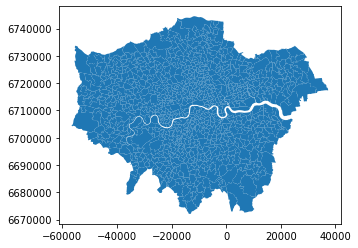

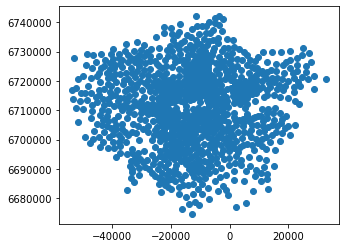

In [41]:
#8.4 Check the two plots

print(gdf.plot())
print(centre_gdf.plot())

In [42]:
#8.5 Import borough outlines, read shapefile and set geometry

url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
path = os.path.join('data', 'statistical-gis-boundaries-london.zip')
r    = urllib.request.urlretrieve(url, path)
z    = zipfile.ZipFile(path)
m    = z.extractall("data")

borough = gpd.read_file('data\statistical-gis-boundaries-london\ESRI\London_Borough_Excluding_MHW.shp')

borough = borough.to_crs(epsg=3857)

In [43]:
#8.6 Define formatting for map

def format_legend(leg, title=None):
    if title is not None:
         leg.set_title(title)
    for i in leg.get_texts():
            bounds = [float(x) for x in i.get_text().split(' - ')]
            b_txt = "{0:.0f} - {1:.0f}".format(bounds[0], bounds[1])
            i.set_text(b_txt)

# cluster analysis 

global Morans I and LISA

# contextual analysis 

   correlation matrix and OLSbivariate regression
  